In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
device = torch.device('cuda')

In [3]:
print(torch.cuda.current_device())

0


In [ ]:
!curl -L "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip"> training.zip
!unzip training.zip

In [ ]:
!curl -L "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip"> training_gd.zip
!unzip training_gd

In [ ]:
!curl -L "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_Data.zip" > testing_data.zip
!unzip testing_data.zip

In [ ]:
!curl -L "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Test_GroundTruth.zip" >testing_gt.zip
!unzip testing_gt.zip

In [ ]:
os.chdir('/content/drive/MyDrive/BisNet_resnet18/')

In [8]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline
import random

from torch.autograd import Variable
from __future__ import print_function
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import init
from torch.utils.data import DataLoader
import torch.utils.model_zoo as modelzoo
from torchvision import datasets, transforms
import torchvision.models as models
import os
from PIL import Image
import torchvision.transforms.functional as TF
import math
from skimage import filters
from skimage.color import rgb2gray
import time
from scipy.io import loadmat
import warnings
warnings.filterwarnings("ignore")
import sys
!pip install xlsxwriter 
import xlsxwriter
from torchvision.utils import save_image

     |████████████████████████████████| 149 kB 7.4 MB/s 


In [9]:
#Loading Train data

class Isic_train_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part1_Training_Data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part1_Training_GroundTruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "ISBI2016_ISIC_Part1_Training_Data", self.imgs[idx])
        mask_path = os.path.join(self.root, "ISBI2016_ISIC_Part1_Training_GroundTruth", self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
#         img = img.resize((224, 224))
        mask = Image.open(mask_path)
#         mask = mask.resize((224, 224))

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            

        return img, mask

    def __len__(self):
        return len(self.imgs)

In [10]:
#Loading Train data

class Isic_test_Dataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part1_Test_Data"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "ISBI2016_ISIC_Part1_Test_GroundTruth"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "ISBI2016_ISIC_Part1_Test_Data", self.imgs[idx])
        mask_path = os.path.join(self.root, "ISBI2016_ISIC_Part1_Test_GroundTruth", self.masks[idx])
        img = Image.open(img_path)#.convert("RGB")
#         img = img.resize((224, 224))
        mask = Image.open(mask_path)
#         mask = mask.resize((224, 224))

        if self.transforms is not None:
            img = self.transforms(img)
            mask = self.transforms(mask)
            
        img_name = self.imgs[idx]
        return img, mask, img_name

    def __len__(self):
        return len(self.imgs)

In [11]:
def my_segmentation_transforms(image):
    angle = 25
    image = TF.rotate(image, angle)
    return image

def scale_image(image):
#     scale = 1.2
    image = TF.affine(img=image, angle=0, translate=(0, 0), scale=1.3, shear=0)
    return image

transform1 = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])#transforms.Resize((224,224)),
transform2 = transforms.Compose([transforms.Resize((224,224)), transforms.RandomHorizontalFlip(1), transforms.ToTensor()])
transform3 = transforms.Compose([transforms.Resize((224,224)), my_segmentation_transforms, transforms.ToTensor()])
transform4 = transforms.Compose([transforms.Resize((224,224)), scale_image, transforms.ToTensor()])

train_dataset     = Isic_train_Dataset('/content', transforms=transform1)
horizontalflipped = Isic_train_Dataset('/content', transforms=transform2)
rotated_image     = Isic_train_Dataset('/content', transforms=transform3)
scaled_image      = Isic_train_Dataset('/content', transforms=transform4)
# data Augmentation

increased_dataset = torch.utils.data.ConcatDataset([train_dataset, horizontalflipped, rotated_image, scaled_image])
lengths = [int(len(increased_dataset)*0.9), int(len(increased_dataset)*0.1)]
train_set, val_set = torch.utils.data.dataset.random_split(increased_dataset, lengths)

test_dataset = Isic_test_Dataset('/content', transforms=transform1)

In [12]:
# hyper-parameters
batch_size = 8

In [13]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [14]:
# lengths of dataset
print('Length of original train data : ', len(train_dataset))
print('Length of Training data       : ', len(train_set))
print('Length of validation data     : ', len(val_set))
print('Length of Testing data        : ', len(test_dataset))

Length of original train data :  900
Length of Training data       :  3240
Length of validation data     :  360
Length of Testing data        :  379


In [ ]:
# dataloaders = {"train": train_loader, "val": valid_loader}
# data_lengths = {"train": len(train_set), "val": len(val_set)}
# len(train_loader), len(valid_loader), len(test_loader)
# 54 , 6, 26 batches of size 15 each

# visualizing Data

    1.Visualizing Train Data

torch.Size([8, 3, 224, 224])
torch.Size([8, 1, 224, 224])


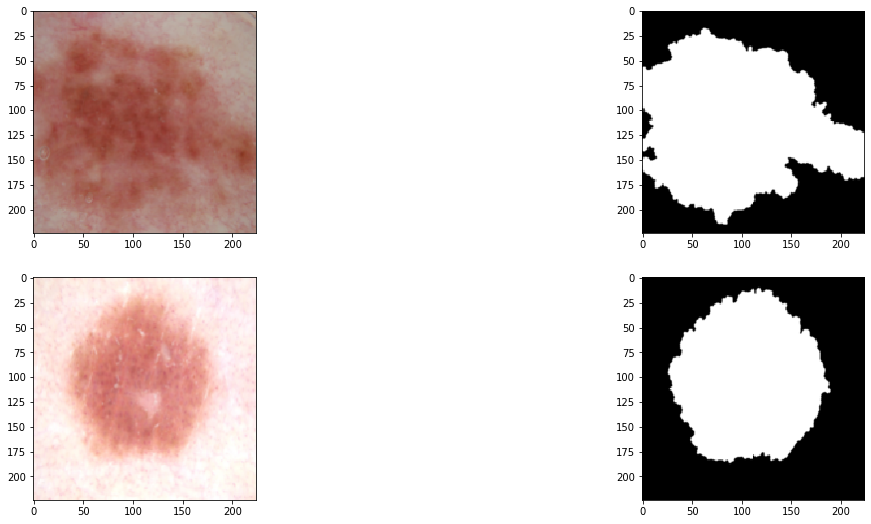

In [15]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

plt.figure(figsize=(20,9))
plt.subplot(2,2,1)
plt.imshow(images[0].permute(1, 2, 0))
plt.subplot(2,2,2)
plt.imshow(labels[0].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
plt.subplot(2,2,3)
plt.imshow(images[1].permute(1, 2, 0))
plt.subplot(2,2,4)
plt.imshow(labels[1].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# f, axarr = plt.subplots(2,2)
# axarr[0,0].imshow(images[0].permute(1, 2, 0)  )
# axarr[0,1].imshow(labels[0].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[1,0].imshow(images[1].permute(1, 2, 0)  )
# axarr[1,1].imshow(labels[1].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[2,0].imshow(images[2].permute(1, 2, 0)  )
# axarr[2,1].imshow(labels[2].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
# axarr[3,0].imshow(images[3].permute(1, 2, 0)  )
# axarr[3,1].imshow(labels[3].permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')

# Model

In [19]:
resnet18_url = 'https://download.pytorch.org/models/resnet34-b627a593.pth'

#  from torch.nn import BatchNorm2d
# def BatchNorm2d(out_chan):
#     return nn.SyncBatchNorm.convert_sync_batchnorm(nn.BatchNorm2d(out_chan))


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class BasicBlock(nn.Module):
    def __init__(self, in_chan, out_chan, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_chan, out_chan, stride)
        self.bn1 = nn.BatchNorm2d(out_chan)
        self.conv2 = conv3x3(out_chan, out_chan)
        self.bn2 = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = None
        if in_chan != out_chan or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_chan, out_chan,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_chan),
                )

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)

        out = shortcut + residual
        out = self.relu(out)
        return out


def create_layer_basic(in_chan, out_chan, bnum, stride=1):
    layers = [BasicBlock(in_chan, out_chan, stride=stride)]
    for i in range(bnum-1):
        layers.append(BasicBlock(out_chan, out_chan, stride=1))
    return nn.Sequential(*layers)


class Resnet18(nn.Module):
    def __init__(self):
        super(Resnet18, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = create_layer_basic(64, 64, bnum=2, stride=1)
        self.layer2 = create_layer_basic(64, 128, bnum=2, stride=2)
        self.layer3 = create_layer_basic(128, 256, bnum=2, stride=2)
        self.layer4 = create_layer_basic(256, 512, bnum=2, stride=2)
        self.init_weight()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        feat8 = self.layer2(x) # 1/8
        feat16 = self.layer3(feat8) # 1/16
        feat32 = self.layer4(feat16) # 1/32
        return feat8, feat16, feat32

    def init_weight(self):
        state_dict = modelzoo.load_url(resnet18_url)
        self_state_dict = self.state_dict()
        #for k, v in state_dict.items():
        #    if 'fc' in k: continue
        #    self_state_dict.update({k: v})
        self.load_state_dict(self_state_dict)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.modules.batchnorm._BatchNorm):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params

In [ ]:
torchvision.models.resnet34(pretrained = True, progress = True)

In [ ]:
# noise = torch.randn(2, 3, 224, 224)
#m = Resnet18()
# # # print(m)
# _, __, out = m(noise)
# print(_.shape, __.shape, out.shape)

In [17]:
class ConvBNReLU(nn.Module):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        self.conv = nn.Conv2d(in_chan,
                out_chan,
                kernel_size = ks,
                stride = stride,
                padding = padding,
                bias = False)
        self.bn = nn.BatchNorm2d(out_chan)
        self.relu = nn.ReLU(inplace=True)
        self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class BiSeNetOutput(nn.Module):
    def __init__(self, in_chan, mid_chan=1, n_classes=1, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        self.conv = nn.Conv2d(in_chan,
                n_classes,
                kernel_size = 3,
                stride = 1,
                padding = 1,
                bias = False)
        self.activation = nn.Sigmoid()
#         self.conv = ConvBNReLU(in_chan, mid_chan, ks=3, stride=1, padding=1)
#         self.conv_out = nn.Conv2d(mid_chan, n_classes, kernel_size=1, bias=False)
#         self.init_weight()

    def forward(self, x):
        x = self.conv(x)
        x = self.activation(x)
        return x

#     def init_weight(self):
#         for ly in self.children():
#             if isinstance(ly, nn.Conv2d):
#                 nn.init.kaiming_normal_(ly.weight, a=1)
#                 if not ly.bias is None: nn.init.constant_(ly.bias, 0)

#     def get_params(self):
#         wd_params, nowd_params = [], []
#         for name, module in self.named_modules():
#             if isinstance(module, (nn.Linear, nn.Conv2d)):
#                 wd_params.append(module.weight)
#                 if not module.bias is None:
#                     nowd_params.append(module.bias)
#             elif isinstance(module, nn.modules.batchnorm._BatchNorm):
#                 nowd_params += list(module.parameters())
#         return wd_params, nowd_params


class AttentionRefinementModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        self.conv = ConvBNReLU(in_chan, out_chan, ks=3, stride=1, padding=1)
        self.conv_atten = nn.Conv2d(out_chan, out_chan, kernel_size= 1, bias=False)
        self.bn_atten = nn.BatchNorm2d(out_chan)
        self.sigmoid_atten = nn.Sigmoid()
        self.init_weight()

    def forward(self, x):
        feat = self.conv(x)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten)
        atten = self.sigmoid_atten(atten)
        out = torch.mul(feat, atten)
        return out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)


class ContextPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(ContextPath, self).__init__()
        self.resnet = Resnet18()
        self.arm16 = AttentionRefinementModule(256, 128)
        self.arm32 = AttentionRefinementModule(512, 128)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_avg = ConvBNReLU(512, 128, ks=1, stride=1, padding=0)

        self.init_weight()

    def forward(self, x):
        H0, W0 = x.size()[2:]
        feat8, feat16, feat32 = self.resnet(x)
        H8, W8 = feat8.size()[2:]
        H16, W16 = feat16.size()[2:]
        H32, W32 = feat32.size()[2:]

        avg = F.avg_pool2d(feat32, feat32.size()[2:])
        avg = self.conv_avg(avg)
        avg_up = F.interpolate(avg, (H32, W32), mode='nearest')

        feat32_arm = self.arm32(feat32)
        feat32_sum = feat32_arm + avg_up
        feat32_up = F.interpolate(feat32_sum, (H16, W16), mode='nearest')
        feat32_up = self.conv_head32(feat32_up)

        feat16_arm = self.arm16(feat16)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = F.interpolate(feat16_sum, (H8, W8), mode='nearest')
        feat16_up = self.conv_head16(feat16_up)

        return feat16_up, feat32_up # x8, x16

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.modules.batchnorm._BatchNorm):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class SpatialPath(nn.Module):
    def __init__(self, *args, **kwargs):
        super(SpatialPath, self).__init__()
        self.conv1 = ConvBNReLU(3, 64, ks=7, stride=2, padding=3)
        self.conv2 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv3 = ConvBNReLU(64, 64, ks=3, stride=2, padding=1)
        self.conv_out = ConvBNReLU(64, 128, ks=1, stride=1, padding=0)
        self.init_weight()

    def forward(self, x):
        feat = self.conv1(x)
        feat = self.conv2(feat)
        feat = self.conv3(feat)
        feat = self.conv_out(feat)
        return feat

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.modules.batchnorm._BatchNorm):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class FeatureFusionModule(nn.Module):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        self.convblk = ConvBNReLU(in_chan, out_chan, ks=1, stride=1, padding=0)
        self.conv1 = nn.Conv2d(out_chan,
                out_chan//4,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.conv2 = nn.Conv2d(out_chan//4,
                out_chan,
                kernel_size = 1,
                stride = 1,
                padding = 0,
                bias = False)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.init_weight()

    def forward(self, fsp, fcp):
        fcat = torch.cat([fsp, fcp], dim=1)
        feat = self.convblk(fcat)
        atten = F.avg_pool2d(feat, feat.size()[2:])
        atten = self.conv1(atten)
        atten = self.relu(atten)
        atten = self.conv2(atten)
        atten = self.sigmoid(atten)
        feat_atten = torch.mul(feat, atten)
        feat_out = feat_atten + feat
        return feat_out

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
            if isinstance(module, (nn.Linear, nn.Conv2d)):
                wd_params.append(module.weight)
                if not module.bias is None:
                    nowd_params.append(module.bias)
            elif isinstance(module, nn.modules.batchnorm._BatchNorm):
                nowd_params += list(module.parameters())
        return wd_params, nowd_params


class BiSeNet(nn.Module):
    def __init__(self, n_classes, *args, **kwargs):
        super(BiSeNet, self).__init__()
        self.cp = ContextPath()
        self.sp = SpatialPath()
        self.ffm = FeatureFusionModule(256, 256)
        self.conv_out = BiSeNetOutput(256, 1, n_classes)
#         self.conv_out16 = BiSeNetOutput(128, 64, n_classes)
#         self.conv_out32 = BiSeNetOutput(128, 64, n_classes)
        self.init_weight()

    def forward(self, x):
        H, W = x.size()[2:]
        feat_cp8, feat_cp16 = self.cp(x)
        feat_sp = self.sp(x)
        feat_fuse = self.ffm(feat_sp, feat_cp8)

        feat_out = self.conv_out(feat_fuse)
#         feat_out16 = self.conv_out16(feat_cp8)
#         feat_out32 = self.conv_out32(feat_cp16)

        feat_out = F.interpolate(feat_out, (H, W), mode='bilinear', align_corners=True)
#         feat_out16 = F.interpolate(feat_out16, (H, W), mode='bilinear', align_corners=True)
#         feat_out32 = F.interpolate(feat_out32, (H, W), mode='bilinear', align_corners=True)
        return feat_out#, feat_out16, feat_out32

    def init_weight(self):
        for ly in self.children():
            if isinstance(ly, nn.Conv2d):
                nn.init.kaiming_normal_(ly.weight, a=1)
                if not ly.bias is None: nn.init.constant_(ly.bias, 0)

    def get_params(self):
        wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params = [], [], [], []
        for name, child in self.named_children():
            child_wd_params, child_nowd_params = child.get_params()
            if isinstance(child, (FeatureFusionModule, BiSeNetOutput)):
                lr_mul_wd_params += child_wd_params
                lr_mul_nowd_params += child_nowd_params
            else:
                wd_params += child_wd_params
                nowd_params += child_nowd_params
        return wd_params, nowd_params, lr_mul_wd_params, lr_mul_nowd_params

In [ ]:
# noise = torch.randn(2, 3, 224, 224)
# m = BiSeNet(1)
# # # print(m)
# out = m(noise)
# print(out.shape)

In [ ]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

# create segmentation model with pretrained encoder
model = smp.(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
).to(device)

In [20]:
learning_rate = 0.001

model = BiSeNet(1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)#, momentum = 0.9, weight_decay = 0.005
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5, last_epoch=-1, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [21]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='bisenet_resnet18_wda.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [22]:
def train_model(model, batch_size, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            data = data.to(device)
            target = target.to(device)
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            data = data.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('bisenet_resnet18_wda.pth'))

    return  model, avg_train_losses, avg_valid_losses

In [23]:
# model = train_model(model, criterion, optimizer, scheduler, num_epochs=100)
# batch_size = 8
n_epochs = 100
patience = 7
model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)

[  1/100] train_loss: 0.35118 valid_loss: 0.27587
Validation loss decreased (inf --> 0.275865).  Saving model ...
[  2/100] train_loss: 0.24716 valid_loss: 0.22816
Validation loss decreased (0.275865 --> 0.228156).  Saving model ...
[  3/100] train_loss: 0.21416 valid_loss: 0.19697
Validation loss decreased (0.228156 --> 0.196968).  Saving model ...
[  4/100] train_loss: 0.20077 valid_loss: 0.19105
Validation loss decreased (0.196968 --> 0.191054).  Saving model ...
[  5/100] train_loss: 0.18926 valid_loss: 0.17130
Validation loss decreased (0.191054 --> 0.171304).  Saving model ...
[  6/100] train_loss: 0.18009 valid_loss: 0.16410
Validation loss decreased (0.171304 --> 0.164103).  Saving model ...
[  7/100] train_loss: 0.17434 valid_loss: 0.15691
Validation loss decreased (0.164103 --> 0.156909).  Saving model ...
[  8/100] train_loss: 0.16396 valid_loss: 0.15103
Validation loss decreased (0.156909 --> 0.151035).  Saving model ...
[  9/100] train_loss: 0.16421 valid_loss: 0.15528
Ear

# Save and Load Model

In [ ]:
# saving and loading Model
# PATH = 'BiSeNet_ISIC2016.pth'
# torch.save(model.state_dict(), PATH)

In [24]:
# #to load weights
model = BiSeNet(1).to(device)
PATH = 'bisenet_resnet18_wda.pth'
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [25]:
#only of the lesion class not the mean. 
"""
Evaluation Criteria:
1. Accuracy
2. IntersectionoverUnion(Jaccard Index)
4. Dice coefficient(F1-score)
6. Specificity
7. Sensitivity
"""

def compute_tp_tn_fn_fp(pred, label):
    '''
    True positive - actual = 1, predicted = 1
    False positive - actual = 1, predicted = 0
    False negative - actual = 0, predicted = 1
    True negative - actual = 0, predicted = 0
    '''
    pred = pred.cpu().numpy().astype('int32')
    label = label.cpu().numpy().astype('int32')
    tp = np.sum((label == 1) & (pred == 1))
    tn = np.sum((label == 0) & (pred == 0))
    fn = np.sum((label == 1) & (pred == 0))
    fp = np.sum((label == 0) & (pred == 1))
    return tp, tn, fp, fn

#2 preferred
def compute_acc(tp, tn, fp, fn):
    return ((tp+tn)/(tp+tn+fp+fn))

def compute_iou(tp, tn, fp, fn):
    return (tp/(tp+fp+fn))

def compute_dc(tp, tn, fp, fn):
    return ((2*tp)/(2*tp + fp+fn))

def compute_meaniou(tp, tn, fp, fn):
    a = (tp/(tp+fp+fn))
    b = (tn/(tn+fn+fp))
    return ((a+b)/2)

def compute_meandc(tp, tn, fp, fn):
    a = ((2*tp)/(2*tp + fp + fn))
    b = ((2*tn)/(2*tn + fp + fn))
    return (a+b)/2

def compute_prec(tp, tn, fp, fn):
    return (tp/(tp + fp + 1e-5))

def compute_rec(tp, tn, fp, fn):
    return (tp/(tp + fn + 1e-5))

def compute_specificity(tp, tn, fp, fn):
    return (tn/(tn + fp))

def compute_sensitivity(tp, tn, fp, fn):
    return (tp/(tp + fn))


def evaluate_model(pred, label):
    tp, tn, fp, fn = compute_tp_tn_fn_fp(pred, label)
    
    acc = compute_acc(tp, tn, fp, fn)
    iou = compute_iou(tp, tn, fp, fn)
    dc  = compute_dc(tp, tn, fp, fn)
#     miou = compute_meaniou(tp, tn, fp, fn)
#     mdc  = compute_meandc(tp, tn, fp, fn)
#     prec = compute_prec(tp, tn, fp, fn)
#     rec = compute_rec(tp, tn, fp, fn)
    spec = compute_specificity(tp, tn, fp, fn)
    sen = compute_sensitivity(tp, tn, fp, fn)
    
    return acc, iou, dc, spec, sen #, miou, mdc, prec, rec


In [26]:
#evaluate model

model.eval()

with torch.no_grad():
    torch.manual_seed(1)
    '''______________________________Evaluating Training Data______________________________________________'''
    print('Training Data')
    count = 0
    accuracy_sum = 0
    jaccard_index = 0
    dice_coe = 0
    specificity = 0
    sensitivity = 0
#     mean_jaccard_index_sum = 0
#     mean_dice_coe_sum = 0
#     precision_sum = 0
#     recall_sum = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)
        
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        accuracy_sum += acc
        jaccard_index += iou
        dice_coe += dc
#         mean_jaccard_index_sum += miou
#         mean_dice_coe_sum += mdc
#         precision_sum += prec
#         recall_sum += rec
        specificity += spec
        sensitivity += sen
        count += 1
        
    accuracy_sum = accuracy_sum / count
    jaccard_index = jaccard_index / count
    dice_coe = dice_coe / count
    specificity = specificity/ count
    sensitivity = sensitivity/ count
#     mean_jaccard_index_sum = mean_jaccard_index_sum / count
#     mean_dice_coe_sum = mean_dice_coe_sum / count
#     precision_sum = precision_sum / count
#     recall_sum = recall_sum / count
    
    print('Accuracy      : |   {:.2f}  |'.format(accuracy_sum*100))
    print('IoU           : |   {:.2f}  |'.format(jaccard_index*100))
    print('DC            : |   {:.2f}  |'.format(dice_coe*100))
    print('Specificity   : |   {:.2f}  |'.format(specificity*100))
    print('Sensitivity   : |   {:.2f}  |'.format(sensitivity*100))
#     print('Mean IoU      : |   {:.2f}  |'.format(mean_jaccard_index_sum*100))
#     print('Mean DC       : |   {:.2f}  |'.format(mean_dice_coe_sum*100))
#     print('Precision     : |   {:.2f}  |'.format(precision_sum*100))
#     print('Recall        : |   {:.2f}  |'.format(recall_sum*100))
    print('-----------------------------------')
    
    '''______________________________Evaluating Validation Data____________________________________________'''
    print('Validation Data')
    count = 0
    accuracy_sum = 0
    jaccard_index = 0
    dice_coe = 0
#     mean_jaccard_index_sum = 0
#     mean_dice_coe_sum = 0
#     precision_sum = 0
#     recall_sum = 0
    specificity = 0
    sensitivity = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        accuracy_sum += acc
        jaccard_index += iou
        dice_coe += dc
#         mean_jaccard_index_sum += miou
#         mean_dice_coe_sum += mdc
#         precision_sum += prec
#         recall_sum += rec
        specificity += spec
        sensitivity += sen
        count += 1
        
    accuracy_sum = accuracy_sum / count
    jaccard_index = jaccard_index / count
    dice_coe = dice_coe / count
#     mean_jaccard_index_sum = mean_jaccard_index_sum / count
#     mean_dice_coe_sum = mean_dice_coe_sum / count
#     precision_sum = precision_sum / count
#     recall_sum = recall_sum / count
    specificity = specificity/ count
    sensitivity = sensitivity/ count
    
    print('Accuracy      : |   {:.2f}  |'.format(accuracy_sum*100))
    print('IoU           : |   {:.2f}  |'.format(jaccard_index*100))
    print('DC            : |   {:.2f}  |'.format(dice_coe*100))
    print('Specificity   : |   {:.2f}  |'.format(specificity*100))
    print('Sensitivity   : |   {:.2f}  |'.format(sensitivity*100))
#     print('Mean IoU      : |   {:.2f}  |'.format(mean_jaccard_index_sum*100))
#     print('Mean DC       : |   {:.2f}  |'.format(mean_dice_coe_sum*100))
#     print('Precision     : |   {:.2f}  |'.format(precision_sum*100))
#     print('Recall        : |   {:.2f}  |'.format(recall_sum*100))
    print('-----------------------------------')
    

Training Data
Accuracy      : |   96.35  |
IoU           : |   88.09  |
DC            : |   93.64  |
Specificity   : |   96.65  |
Sensitivity   : |   95.18  |
-----------------------------------
Validation Data
Accuracy      : |   95.29  |
IoU           : |   85.93  |
DC            : |   92.39  |
Specificity   : |   96.33  |
Sensitivity   : |   92.95  |
-----------------------------------


Testing Data
--------------------------------------------------
Accuracy       :|   93.96  |
IoU            :|   79.38  |
DC             :|   87.43  |
Mean IoU       :|   93.50  |
Mean DC        :|   92.15  |
--------------------------------------------------
Visualizing Results


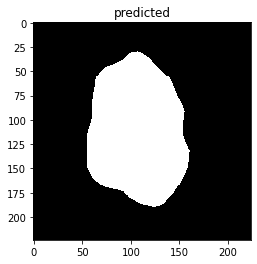

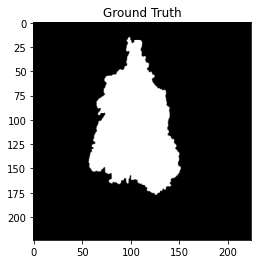

In [27]:
#on Test Set

workbook = xlsxwriter.Workbook('bisenet_resnet18_wda.xlsx')
worksheet = workbook.add_worksheet()
worksheet.write(0, 0, "Image_name")
worksheet.write(0, 1, "Acc")
worksheet.write(0, 2, "IoU")
worksheet.write(0, 3, "DC")
worksheet.write(0, 4, "Spec")
worksheet.write(0, 5, "Sen")
# worksheet.write(0, 6, "Prec")
# worksheet.write(0, 7, "Rec")
row = 1
col = 0


model.eval()

with torch.no_grad():
    torch.manual_seed(1)
    '''______________________________Evaluating Testing Data_______________________________________________'''
    print('Testing Data')
    
    acc_sum = []
    iou_sum = []
    dc_sum = []
    speci_sum = []
    sens_sum = []
#     miou_sum = []
#     mdc_sum = []
#     prec_sum = []
#     rec_sum = []
    
    for images, labels, image_name in test_loader:
        images = images.to(device)
        labels = labels.to(device)    #labels have binary value either 0 or 1
        outputs = model(images)       #outputs have value in range between 0 and 1
        outputs = torch.where(outputs > 0.5, 1.0, 0.0)

#         Saving the predicted Images
        pred_image = outputs.clone().detach()
        pred_image = pred_image.reshape(labels.shape[1], labels.shape[2], labels.shape[3])
        pred_image *= 255
        path = os.path.join("/content/Predicted_images/"+image_name[0])
        save_image(pred_image, path)
#         img = Image.fromarray(pred_image)
#         img.save(os.path.join("predicted_image/"+image_name))
#         im1 = Image.save("predicted_image/", image_name) 
        
#         Computing evaluation metrics
        output_image = outputs[0]
        label_image = labels[0]
        acc, iou, dc, spec, sen = evaluate_model(outputs, labels)
        
        acc_sum.append(acc)
        iou_sum.append(iou)
        dc_sum.append(dc)
        speci_sum.append(spec)
        sens_sum.append(sen)
#         prec_sum.append(prec)
#         rec_sum.append(rec)
        
        #writing the data in excel sheet
        col = 0
        worksheet.write(row, col, image_name[0])
        temp = "{:.2f}".format(acc*100)
        worksheet.write(row, col+1, temp)
        temp = "{:.2f}".format(iou*100)
        worksheet.write(row, col+2, temp)
        temp = "{:.2f}".format(dc*100)
        worksheet.write(row, col+3, temp)
        temp = "{:.2f}".format(spec*100)
        worksheet.write(row, col+4, temp)
        temp = "{:.2f}".format(sen*100)
        worksheet.write(row, col+5, temp)
#         temp = "{:.2f}".format(prec*100)
#         worksheet.write(row, col+6, temp)
#         temp = "{:.2f}".format(rec*100)
#         worksheet.write(row, col+7, temp)
        row += 1
        
#         print('---------------------')
#         print(image_name)
#         print('Accuracy :{:.2f} '.format(acc*100))
#         print('IoU      :{:.2f} '.format(iou*100))
#         print('dc       :{:.2f} '.format(dc*100))
#         print('miou     :{:.2f} '.format(miou*100))
#         print('mdc      :{:.2f} '.format(mdc*100))
#         print('prec     :{:.2f} '.format(prec*100))
#         print('Rec      :{:.2f} '.format(rec*100))
#         print('---------------------')
    
    acc = sum(acc_sum)/len(acc_sum)
    iou = sum(iou_sum)/len(iou_sum)
    dc = sum(dc_sum)/len(dc_sum)
    spec = sum(speci_sum)/len(speci_sum)
    sen = sum(sens_sum)/len(sens_sum)
#     prec = sum(prec_sum)/len(prec_sum)
#     rec = sum(rec_sum)/len(rec_sum)
    
    print('--------------------------------------------------')
    print('Accuracy       :|   {:.2f}  |'.format(acc*100))
    print('IoU            :|   {:.2f}  |'.format(iou*100))
    print('DC             :|   {:.2f}  |'.format(dc*100))
    print('Mean IoU       :|   {:.2f}  |'.format(spec*100))
    print('Mean DC        :|   {:.2f}  |'.format(sen*100))
#     print('Precision      :|   {:.2f}  |'.format(prec*100))
#     print('Recall         :|   {:.2f}  |'.format(rec*100))
    print('--------------------------------------------------')
    print("Visualizing Results")
    output_image = output_image*255
    label_image = label_image*255
    plt.figure(1)
    plt.imshow(output_image.cpu().permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("predicted")
    plt.figure(2)
    plt.imshow(label_image.cpu().permute(1, 2, 0)[:,:,0], cmap='gray', interpolation='none')
    plt.title("Ground Truth")
    
workbook.close()        

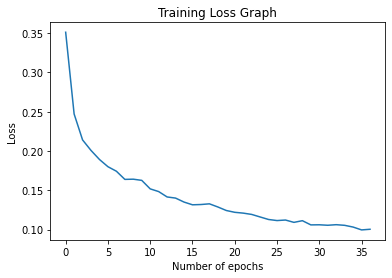

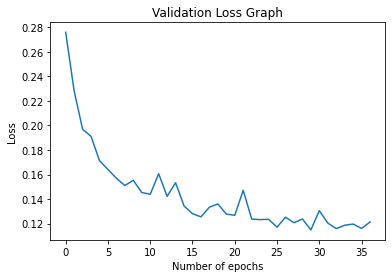

In [28]:
# Loss Graph
plt.figure(1)
plt.plot(train_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Training Loss Graph')
plt.show()
plt.figure(2)
plt.plot(valid_loss)
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.title('Validation Loss Graph')
plt.show()